In [393]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import numpy as np
# import leafmap.leafmap as leafmap
import leafmap.foliumap as leafmap
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from typing import List
from scipy.ndimage import zoom
from matplotlib import cm
from matplotlib.colors import ListedColormap, BoundaryNorm

In [19]:
# Caminhos
raster_path = '../LiDAR_produtos/2017/BHM-2017-50cm.tiff'   # raster

# Carregar feições
gdf = gpd.read_file('data/SIRGAS_GPKG_favela.gpkg')
gdf.geometry = gdf.buffer(0)

In [20]:
# Selecionar a feição (exemplo: primeira)
favela_geom = gdf.loc[gdf.fv_nome == 'São Remo', :].geometry.values.tolist()

favelas_test = [
    "Heliópolis",
    "Cocaia I",
    "Paraisópolis",
    "Futuro Melhor",
    "São Remo"
]

In [21]:
# Selecionando gdf com a coluna 'fv_nome'
favelas_filtradas = gdf[gdf['fv_nome'].isin(favelas_test)]

In [22]:
favelas_filtradas.dissolve(by='fv_nome').reset_index()

,fv_nome,geometry,fv_data,fv_nom_sec,fv_tp_prop,fv_domicil
0,Cocaia I,"POLYGON ((329257.063 7372067.335, 329264.199 7...",2016-04-20,-,1,618
1,Futuro Melhor,"POLYGON ((329713.897 7405216.47, 329710.844 74...",2016-04-12,Peri Alto,1,1500
2,Heliópolis,"MULTIPOLYGON (((337198.456 7388304.423, 337197...",2016-04-04,-,1,15843
3,Paraisópolis,"POLYGON ((323327.527 7386833.606, 323328.54 73...",2016-04-18,-,1,17159
4,São Remo,"POLYGON ((322040.878 7393008.182, 321974.935 7...",2017-08-03,-,1,2000


In [23]:
# Abrir raster e recortar pela feição
with rasterio.open(raster_path) as src:
    print("Raster CRS:", src.crs)
    print("Bounds do raster:", src.bounds)
    print("Bounds da favela 0:", gdf.loc[gdf.fv_nome == 'São Remo', :].geometry.bounds)
    out_image, out_transform = mask(src, favela_geom, crop=True)
    out_data = out_image[0]

    # Filtrar valores válidos
    valid_data = out_data[out_data != src.nodata]

# Ordenar os valores
sorted_data = np.sort(valid_data)

Raster CRS: EPSG:31983
Bounds do raster: BoundingBox(left=313179.5, bottom=7343480.5, right=360683.0, top=7416432.5)
Bounds da favela 0:               minx          miny           maxx          maxy
668  321740.305639  7.392975e+06  322166.723848  7.393369e+06


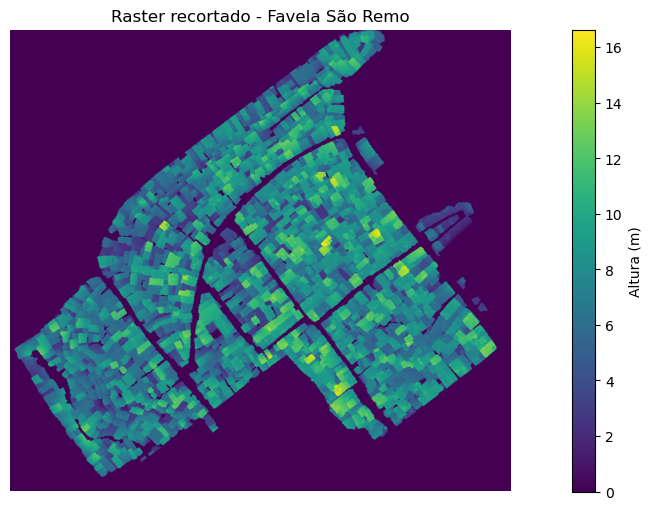

In [48]:
# Plot simples com colormap
plt.figure(figsize=(16, 6))
plt.imshow(out_data, cmap='viridis')
plt.colorbar(label="Altura (m)")
plt.title("Raster recortado - Favela São Remo")
plt.axis('off')
plt.show()

In [51]:
out_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(789, 854), dtype=float32)

In [65]:
mask_favela = geometry_mask(
    geometries=favela_geom,
    transform=out_transform,
    invert=True,  # True = interior da geometria será False (mapeado)
    out_shape=out_data.shape
)

In [173]:
# Binarização: cheios = 1, vazios = 0
vazios = np.where(((out_data == 0.) & (mask_favela)), 1., 0.)

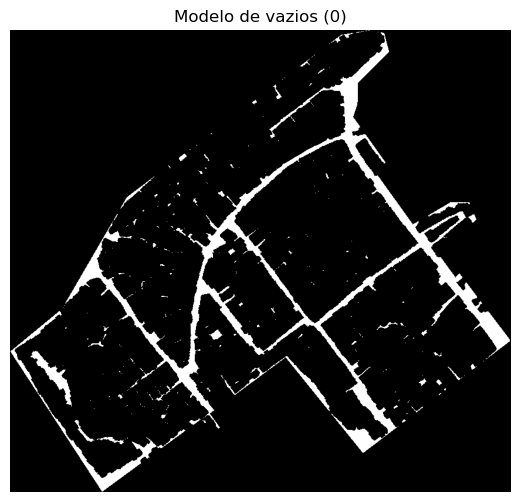

In [174]:
plt.figure(figsize=(8, 6))
plt.imshow(vazios, cmap='gray')
plt.title("Modelo de vazios (0)")
plt.axis('off')
plt.show()

In [201]:
kernel = np.ones((3, 3), dtype=int)
conv = convolve(vazios, kernel, mode='constant', cval=0)

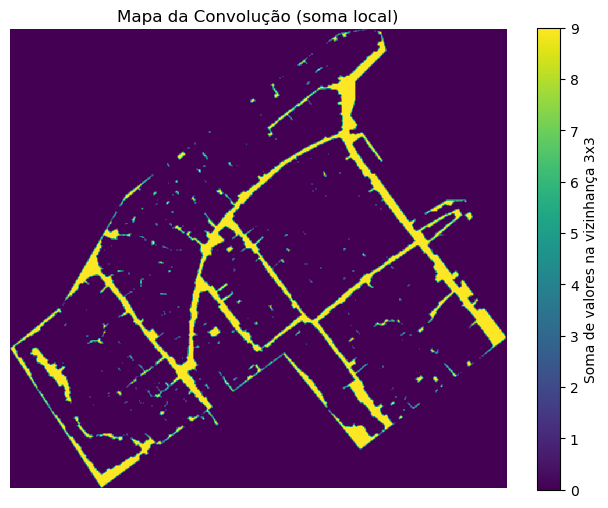

In [202]:
plt.figure(figsize=(8, 6))
plt.imshow(conv, cmap='viridis', interpolation='none')
plt.colorbar(label='Soma de valores na vizinhança 3x3')
plt.title('Mapa da Convolução (soma local)')
plt.axis('off')
plt.show()

In [149]:
print("Valores únicos em conv:", np.unique(conv, return_counts=True))

Valores únicos em conv: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([609562,   8080,   4189,   4689,   3372,   2994,   3963,   3124,
         4654,  29179]))


In [271]:
vazios_isolados = ((vazios == 1.) & (conv <= 5)).astype(np.uint8)

In [272]:
print("Valores únicos em vazios_isolados:", np.unique(vazios_isolados, return_counts=True))

Valores únicos em vazios_isolados: (array([0, 1], dtype=uint8), array([669780,   4026]))


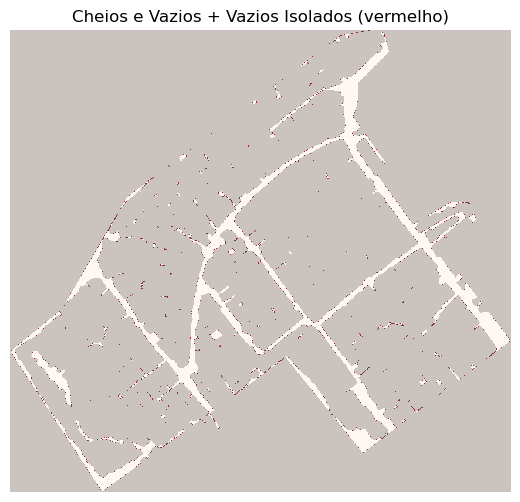

In [273]:
# Crie a figura e o eixo
fig, ax = plt.subplots(figsize=(8, 6))

# Fundo: cheios e vazios (bin_cheios) em tons de cinza
ax.imshow(vazios, cmap='gray', interpolation='none')

# Sobreposição: vazios isolados em vermelho com transparência
ax.imshow(vazios_isolados, cmap='Reds', alpha=0.8, interpolation='none')

# Ajustes visuais
ax.set_title("Cheios e Vazios + Vazios Isolados (vermelho)")
ax.axis('off')

plt.show()

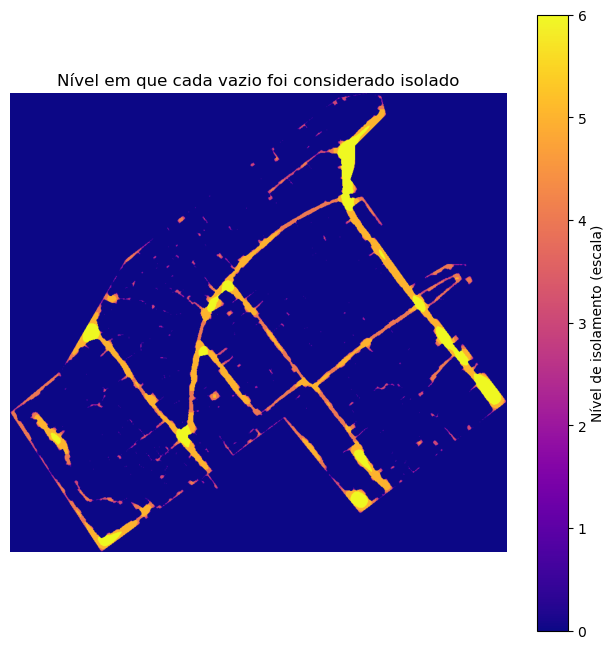

In [355]:
# Cópia da matriz original que será modificada a cada iteração
vazios_iter = vazios.copy()

# Número de iterações / escalas
n_iteracoes = 6
# Janelas: 3x3, 5x5, 9x9, 17x17, ...
tamanhos_janela = [2**i + 1 for i in range(n_iteracoes)][1:]
tamanhos_janela

# Array de saída: armazena o nível em que o pixel foi considerado isolado
codificado_isolados = np.zeros_like(vazios, dtype=np.uint8)

# Iterações com janelas crescentes
for idx, tam in enumerate(tamanhos_janela):
    kernel = np.ones((tam, tam), dtype=int)

    # Convolução: conta quantos vizinhos são 1 (vazios)
    conv = convolve(vazios_iter, kernel, mode='constant', cval=0)

    # Define limite como metade dos vizinhos
    limite = kernel.sum() // 2

    # Identifica vazios isolados nessa escala
    isolados = ((vazios_iter == 1) & (conv <= limite))

    # Atribui o valor do nível da iteração onde o pixel foi considerado isolado
    codificado_isolados[isolados] = idx + 1  # começa em 1, 2, 3...

    # Remove os isolados do raster para próximas iterações
    vazios_iter = np.where(isolados, 0, vazios_iter)

# Atribuir uma classe final aos vazios restantes
classe_final = idx + 2
codificado_isolados[(vazios_iter == 1)] = classe_final

# --- Visualização final ---
plt.figure(figsize=(8, 8))
plt.imshow(codificado_isolados, cmap='plasma')
plt.colorbar(label='Nível de isolamento (escala)')
plt.title('Nível em que cada vazio foi considerado isolado')
plt.axis('off')
plt.show()

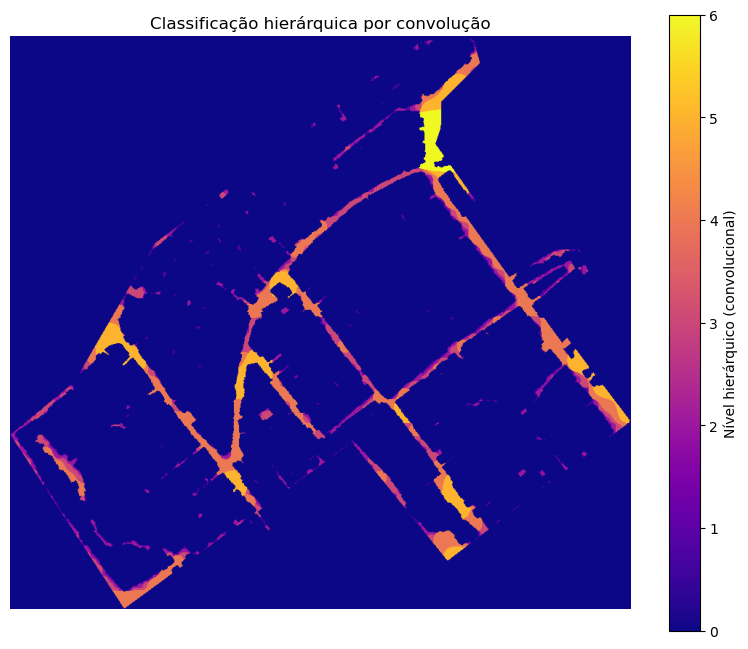

In [382]:
# --- Função para gerar a pirâmide com convoluções 3x3 ---
def gerar_piramide_convolucional_maioria(base_array: np.ndarray, niveis: int = 6) -> List[np.ndarray]:
    piramide = [base_array.copy()]
    atual = base_array.copy()

    for _ in range(1, niveis):
        # Convolução com kernel 3x3
        kernel = np.ones((3, 3), dtype=int)
        conv = convolve(atual, kernel, mode='constant', cval=0)

        # Aplica limiar de maioria (>= 5 em 9 vizinhos)
        maioria = (conv >= 5).astype(np.uint8)

        # Downsampling 2x2
        h, w = maioria.shape
        h_crop = h - (h % 2)
        w_crop = w - (w % 2)
        reduzido = maioria[:h_crop, :w_crop].reshape(h_crop // 2, 2, w_crop // 2, 2).mean(axis=(1, 3)) >= 0.5
        reduzido = reduzido.astype(np.uint8)

        piramide.append(reduzido)
        atual = reduzido

    return piramide

# # --- Função para propagar os valores da pirâmide para o raster original ---
# def propagar_para_base_convolucional(piramide: List[np.ndarray], base_shape: tuple) -> np.ndarray:
#     resultado = np.zeros(base_shape, dtype=np.uint8)

#     for nivel, reduzido in enumerate(piramide[1:], start=1):
#         escala_y = base_shape[0] / reduzido.shape[0]
#         escala_x = base_shape[1] / reduzido.shape[1]

#         upscaled = zoom(reduzido, (escala_y, escala_x), order=0)

#         upscaled_corrigido = np.zeros(base_shape, dtype=np.uint8)
#         h, w = upscaled.shape
#         upscaled_corrigido[:h, :w] = upscaled[:base_shape[0], :base_shape[1]]

#         mask = (resultado == 0) & (upscaled_corrigido == 1)
#         resultado[mask] = nivel

#     return resultado

def propagar_para_base_convolucional(vazios: np.ndarray, piramide: List[np.ndarray]) -> np.ndarray:
    """
    Propaga os níveis da pirâmide convolucional para a base, preenchendo apenas os pixels
    que são vazios no raster original, e priorizando os níveis mais agregados.
    """
    base_shape = vazios.shape
    resultado = np.zeros(base_shape, dtype=np.uint8)

    # Itera da camada mais agregada para a menos agregada (topo → base)
    for nivel in reversed(range(1, len(piramide))):
        reduzido = piramide[nivel]
        escala_y = base_shape[0] / reduzido.shape[0]
        escala_x = base_shape[1] / reduzido.shape[1]

        # Upscale para o tamanho original
        upscaled = zoom(reduzido, (escala_y, escala_x), order=2)

        # Corrigir tamanho se necessário
        upscaled_corrigido = np.zeros(base_shape, dtype=np.uint8)
        h, w = upscaled.shape
        upscaled_corrigido[:h, :w] = upscaled[:base_shape[0], :base_shape[1]]

        # Máscara: só onde era vazio originalmente e ainda não foi preenchido
        mask = (resultado == 0) & (upscaled_corrigido == 1) & (vazios == 1)
        resultado[mask] = nivel

    return resultado

# Gerar pirâmide
piramide = gerar_piramide_convolucional_maioria(vazios, niveis=10)

# Propagar níveis
resultado_final = propagar_para_base_convolucional(vazios, piramide)

# Visualizar
plt.figure(figsize=(10, 8))
plt.imshow(resultado_final, cmap='plasma')
plt.colorbar(label='Nível hierárquico (convolucional)')
plt.title('Classificação hierárquica por convolução')
plt.axis('off')
plt.show()

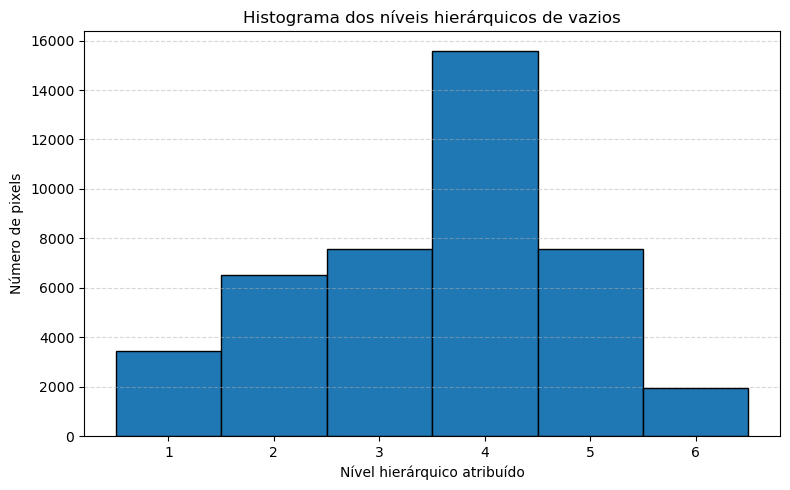

In [383]:
# Filtra apenas os valores maiores que 0 (ou seja, que receberam algum nível)
valores_validos = resultado_final[resultado_final > 0]

# Cria histograma
plt.figure(figsize=(8, 5))
plt.hist(valores_validos, bins=np.arange(1, valores_validos.max() + 2) - 0.5, edgecolor='black')

# Ajustes visuais
plt.xticks(range(1, valores_validos.max() + 1))
plt.xlabel("Nível hierárquico atribuído")
plt.ylabel("Número de pixels")
plt.title("Histograma dos níveis hierárquicos de vazios")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [385]:
tamanho_pixel_base = 0.5  # metros, por exemplo
niveis = 10

tamanhos_por_nivel = [tamanho_pixel_base * (2 ** n) for n in range(niveis)]
print(tamanhos_por_nivel)

[0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0]


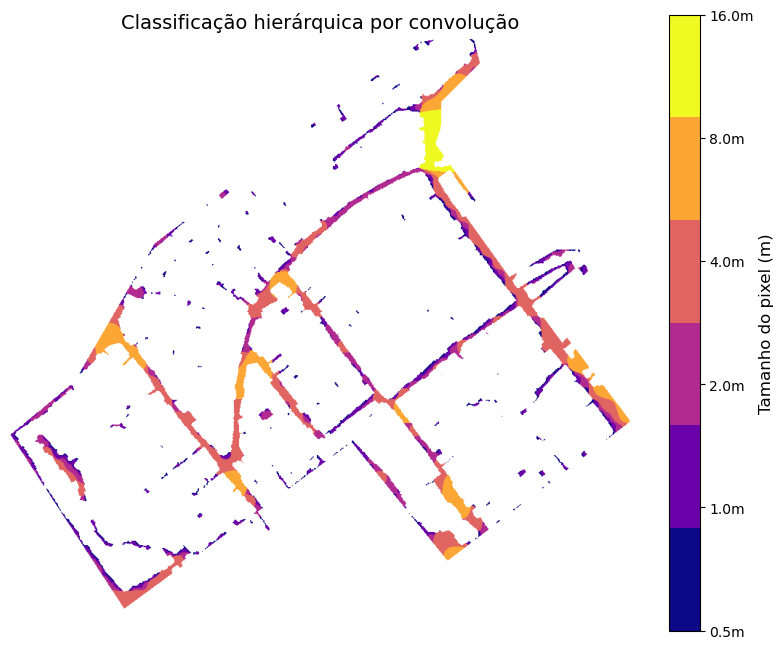

In [398]:
# --- Função para gerar a pirâmide com convolução ---
def gerar_piramide_convolucional_maioria(base_array: np.ndarray, pixel_size_base: float, niveis: int = 6):
    piramide = [base_array.copy()]
    resolucoes = [pixel_size_base]
    atual = base_array.copy()

    for _ in range(1, niveis):
        kernel = np.ones((3, 3), dtype=int)
        conv = convolve(atual, kernel, mode='constant', cval=0)
        maioria = (conv >= 5).astype(np.uint8)

        h, w = maioria.shape
        h_crop = h - (h % 2)
        w_crop = w - (w % 2)
        reduzido = maioria[:h_crop, :w_crop].reshape(h_crop // 2, 2, w_crop // 2, 2).mean(axis=(1, 3)) >= 0.5
        reduzido = reduzido.astype(np.uint8)

        piramide.append(reduzido)
        resolucoes.append(resolucoes[-1] * 2)
        atual = reduzido

    return piramide, resolucoes

# --- Propagação completa incluindo nível 0 ---
def propagar_para_base_convolucional(vazios: np.ndarray, piramide: List[np.ndarray]) -> np.ndarray:
    base_shape = vazios.shape
    resultado = np.zeros(base_shape, dtype=np.uint8)

    for nivel in reversed(range(len(piramide))):  # agora inclui o nível 0
        reduzido = piramide[nivel]
        escala_y = base_shape[0] / reduzido.shape[0]
        escala_x = base_shape[1] / reduzido.shape[1]

        upscaled = zoom(reduzido, (escala_y, escala_x), order=2)

        upscaled_corrigido = np.zeros(base_shape, dtype=np.uint8)
        h, w = upscaled.shape
        upscaled_corrigido[:h, :w] = upscaled[:base_shape[0], :base_shape[1]]

        mask = (resultado == 0) & (upscaled_corrigido == 1) & (vazios == 1)
        resultado[mask] = nivel

    return resultado

# === EXEMPLO DE USO ===

# Suponha que você tenha a matriz `vazios` e o tamanho do pixel base
# pixel_size_base = 0.5
# vazios = np.random.choice([0, 1], size=(150, 150), p=[0.7, 0.3])

n_niveis = 10
piramide, resolucoes = gerar_piramide_convolucional_maioria(vazios, pixel_size_base=0.5, niveis=n_niveis)
resultado_final = propagar_para_base_convolucional(vazios, piramide)

# --- Máscara para ocultar os pixels de nível 0 ---
dados_mascarados = np.ma.masked_where(resultado_final == 0, resultado_final)

# --- Colormap ---
n_niveis = resultado_final.max()  # considera até o maior nível atribuído
cmap = cm.get_cmap('plasma', n_niveis)
cmap.set_bad(color='white')  # nível 0 oculto em branco

# --- Plotagem ---
plt.figure(figsize=(10, 8))
im = plt.imshow(dados_mascarados, cmap=cmap)

# --- Ajustar os ticks para os níveis presentes (1 até n_niveis) ---
ticks = list(range(1, n_niveis + 1))
labels = [f"{resolucoes[i - 1]:.1f}m" for i in ticks]  # i-1 porque resolucoes[0] = nível 1

# --- Colorbar com rótulos corretos ---
cbar = plt.colorbar(im, ticks=ticks)
cbar.set_label("Tamanho do pixel (m)", fontsize=12)
cbar.set_ticklabels(labels)

plt.title("Classificação hierárquica por convolução", fontsize=14)
plt.axis('off')
plt.show()